# Peak fitting demo

Here we use the problem of fitting peaks in spectroscopy data to demonstrate how to construct
posterior distributions as classes which can be used with the MCMC samplers in ``inference.mcmc``.

In [1]:
import matplotlib.pyplot as plt
from numpy import linspace, sqrt, pi, array
from numpy.random import normal

In [2]:
class SpectroPosterior(object):
    def __init__(self, wavelength=None, intensity=None, errors=None):
        """
        The __init__ should be used to pass all data necessary for calculating the 
        log-posterior probability which will be returned by the __call__ method.

        Typically this includes experimental measurements with their associated 
        uncertainties, and any relevant physical constants.
        """
        # store experimental data
        self.x = wavelength
        self.y = intensity
        self.sigma = errors

        # Central wavelengths of the lines are known constants:
        self.c1 = 422.
        self.c2 = 428.

    def __call__(self, theta):
        """
        When an instance of the posterior class is called as a function, this method is 
        invoked. All inference-tools samplers require a function which maps some set of 
        model parameters 'theta' to a log-probability density.

        The log-posterior need only be defined up to a constant, as MCMC samplers only 
        require differences between log-probabilities to function.
        This means the log-posterior can be written as the sum of the log-likelihood
        and log-prior functions:
        """
        return self.likelihood(theta) + self.prior(theta)

    def prior(self, theta):
        """
        This is a place-holder function which serves as an example of how a prior can be
        incorporated into the posterior class. Priors which are either uniform between
        2 chosen values, or simply non-negative should instead be enforced using options 
        in the sampler classes.
        """
        return 0.

    def likelihood(self, theta):
        """
        In this example we assume that the errors on our data are Gaussian, such that the 
        log-likelihood takes the form given below:
        """
        return -0.5*( ((self.y - self.forward_model(self.x, theta)) / self.sigma)**2 ).sum()

    def forward_model(self, x, theta):
        """
        The forward model must make a prediction of the experimental data we would expect to
        measure given a specific state of the system, which is specified by the model parameters 
        theta.
        """
        # unpack the model parameters
        A1, w1, A2, w2, bg = theta
        # evaluate the peaks
        peak_1 = A1 / ((1 + ((x - self.c1)/w1)**2)*(pi*w1))
        peak_2 = A2 / ((1 + ((x - self.c2)/w2)**2)*(pi*w2))
        # return the prediction of the data
        return peak_1 + peak_2 + bg

In [3]:
# Create some simulated data
N = 30
x_data = linspace(410, 440, N)
theta = [1000, 2, 400, 1.5, 35]
y_data = SpectroPosterior().forward_model(x_data, theta)
errors = sqrt(y_data+1)+2
y_data += normal(size=N)*errors

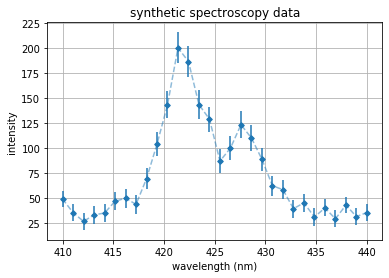

In [4]:
# plot the simulated data we're going to use
plt.errorbar(x_data, y_data, errors, marker = 'D', ls = 'none', markersize = 4)
plt.plot(x_data, y_data, alpha = 0.5, c = 'C0', ls = 'dashed')
plt.title('synthetic spectroscopy data')
plt.xlabel('wavelength (nm)')
plt.ylabel('intensity')
plt.grid()
plt.show()

In [5]:
# create the posterior object
posterior = SpectroPosterior(wavelength=x_data, intensity=y_data, errors=errors)

# create the markov chain object
from inference.mcmc import PcaChain
chain = PcaChain( posterior = posterior, start = [600, 1, 600, 1, 15] )

# generate a sample by advancing the chain
chain.advance(50000)

  advancing chain:   [ complete - 50000 steps taken in 0:00:25 ]      


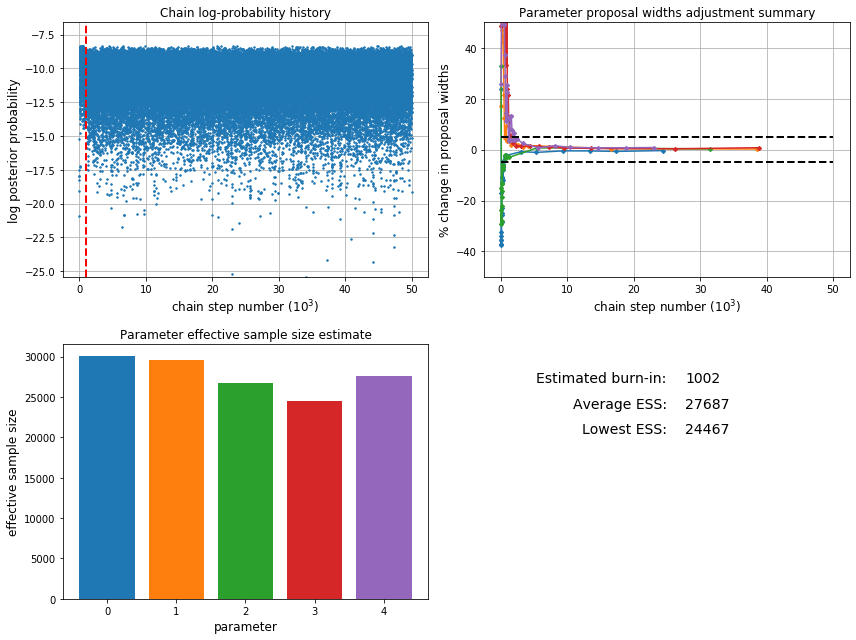

In [6]:
# we can check the status of the chain using the plot_diagnostics method
chain.plot_diagnostics()

We can automatically set sensible burn and thin values for the sample:

In [7]:
chain.autoselect_burn()
chain.autoselect_thin()

[ burn-in set to 1002 | 2.0% of total samples ]
[ thinning factor set to 2 | thinned sample size is 24500 ]


We can plot all the possible 1D and 2D marginal distirbutions of the posterior (or a sub-set of them) using the ``matrix_plot()`` method:

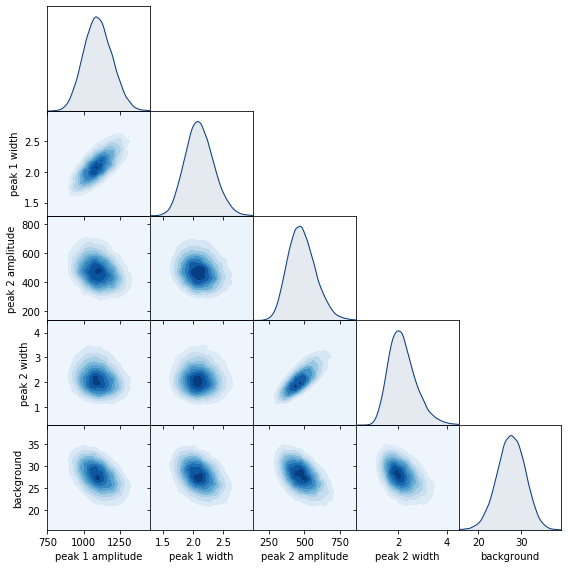

In [8]:
labels = ['peak 1 amplitude', 'peak 1 width', 'peak 2 amplitude', 'peak 2 width', 'background']
chain.matrix_plot(labels=labels)

We can easily estimate 1D marginal distributions for any parameter using the ``get_marginal()`` method:

In [9]:
w1_pdf = chain.get_marginal(1, unimodal = True)
w2_pdf = chain.get_marginal(3, unimodal = True)

``get_marginal()`` returns a 'density estimator' object, which can be called as a function to return the value of the pdf at any point:

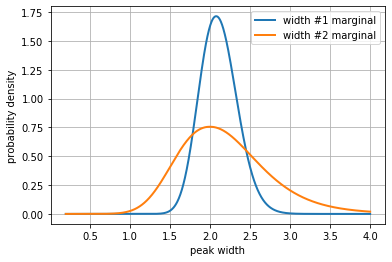

In [10]:
ax = linspace(0.2, 4., 1000)
plt.plot(ax, w1_pdf(ax), label = 'width #1 marginal', lw = 2)
plt.plot(ax, w2_pdf(ax), label = 'width #2 marginal', lw = 2)
plt.xlabel('peak width')
plt.ylabel('probability density')
plt.legend()
plt.grid()
plt.show()

You may also want to assess the level of uncertainty in the model predictions.
This can be done easily by passing each sample through the forward-model
and observing the distribution of model expressions that result.

First, retrieve the sample using the `get_sample()` method, and pass each through the forward model:

In [11]:
# generate an axis on which to evaluate the model
M = 500
x_fits = linspace(400, 450, M)
# get the sample
sample = chain.get_sample()
# pass each through the forward model
curves = array([ posterior.forward_model(x_fits, theta) for theta in sample])

We can use the `hdi_plot` function from the `plotting` module to plot highest-density intervals for each point where the model is evaluated:

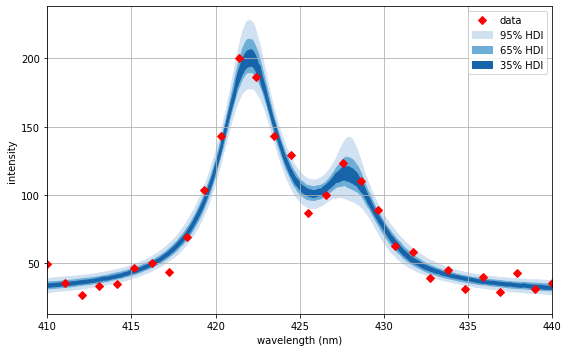

In [12]:
# construct the plot
plt.figure(figsize = (8,5))

# plot all the intervals
from inference.plotting import hdi_plot
hdi_plot(x_fits, curves, intervals = (0.35, 0.65, 0.95))

# plot the data
plt.plot( x_data, y_data, 'D', c = 'red', label = 'data')
plt.xlabel('wavelength (nm)')
plt.ylabel('intensity')
plt.xlim([410, 440])
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()